In [1]:
import torch; 
print(torch.__version__, torch.cuda.is_available())
print(torch.cuda.device_count())

2.0.0+cu117 True
1


In [1]:
import cv2
import torch
import time
import os
import numpy as np

from utils.inference.image_processing import crop_face, get_final_image, show_images, get_only_swaped_image
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

/home/ubuntu-gpu/project/laboratory/ghost-train/.venv/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/home/ubuntu-gpu/project/laboratory/ghost-train/.venv/lib/python3.8/site-packages/mxnet/numpy/utils.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = onp.bool
/home/ubuntu-gpu/project/laboratory/ghost-train/.venv/lib/python3.8/site-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replace

### Load Models

In [2]:
G_path = 'weights/G_unet_2blocks.pth'
target_path = 'examples/images/target_images/006.jpg'
source_path = 'examples/images/source_images/aoyama2.jpg'

In [3]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load(G_path, map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
# 超解像度を使用する場合はuse_sr=Trueを、使用しない場合はuse_sr=Falseを設定する。
use_sr = False
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[02:39:18] /work/mxnet/src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[02:39:18] /work/mxnet/src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!


### Set here path to source image and video for faceswap

In [4]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
image_to_image = True

if image_to_image:
    path_to_target = target_path
else:
    path_to_video = 'examples/videos/random_gif.gif'
source_full = cv2.imread(source_path)
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this
BS = 60


# check, if we can detect face on the source image
try:    
    source = crop_face(source_full, app, crop_size)[0]
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

# read video and find target image in the video that contains at least 1 face
if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
    print(len(full_frames))
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)



Everything is ok!
1


In [5]:
# Model Inference
START_TIME = time.time()
final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=BS)

100%|██████████| 1/1 [00:00<00:00, 17.19it/s]
1it [00:00, 985.97it/s]
1it [00:00, 2241.74it/s]
100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


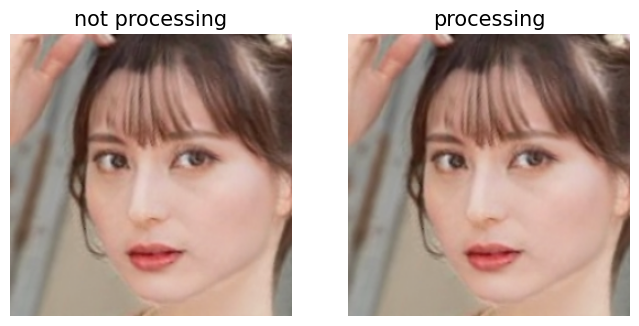

/home/ubuntu-gpu/project/laboratory/ghost-train/.venv/lib/python3.8/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
/home/ubuntu-gpu/project/laboratory/ghost-train/.venv/lib/python3.8/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):


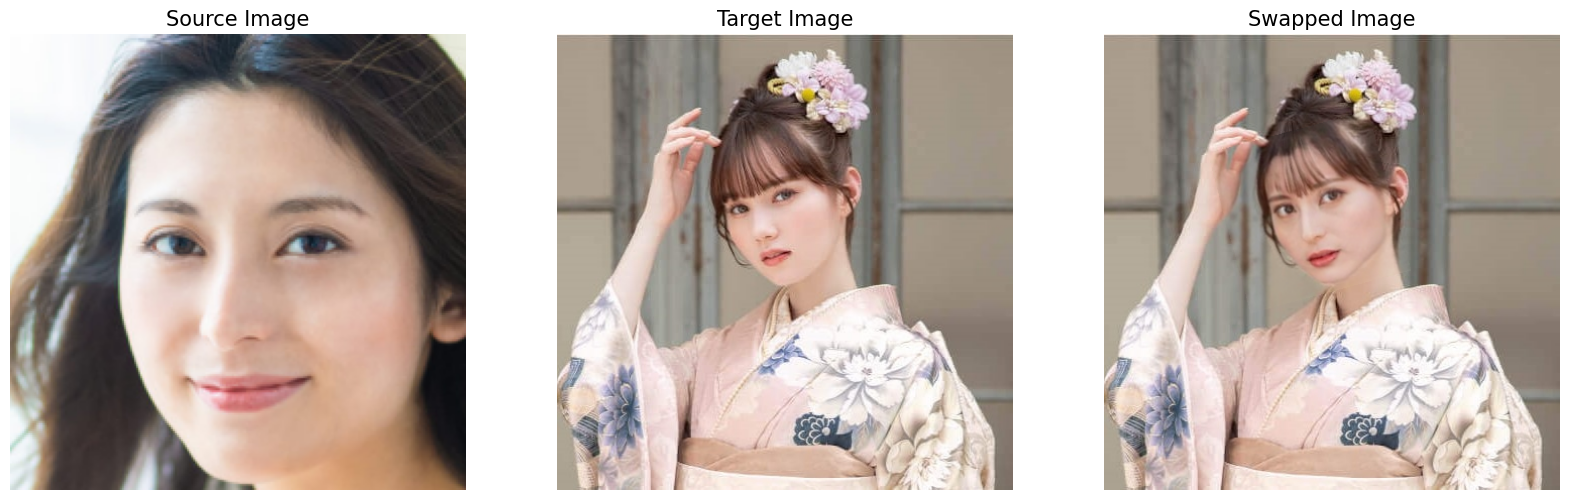

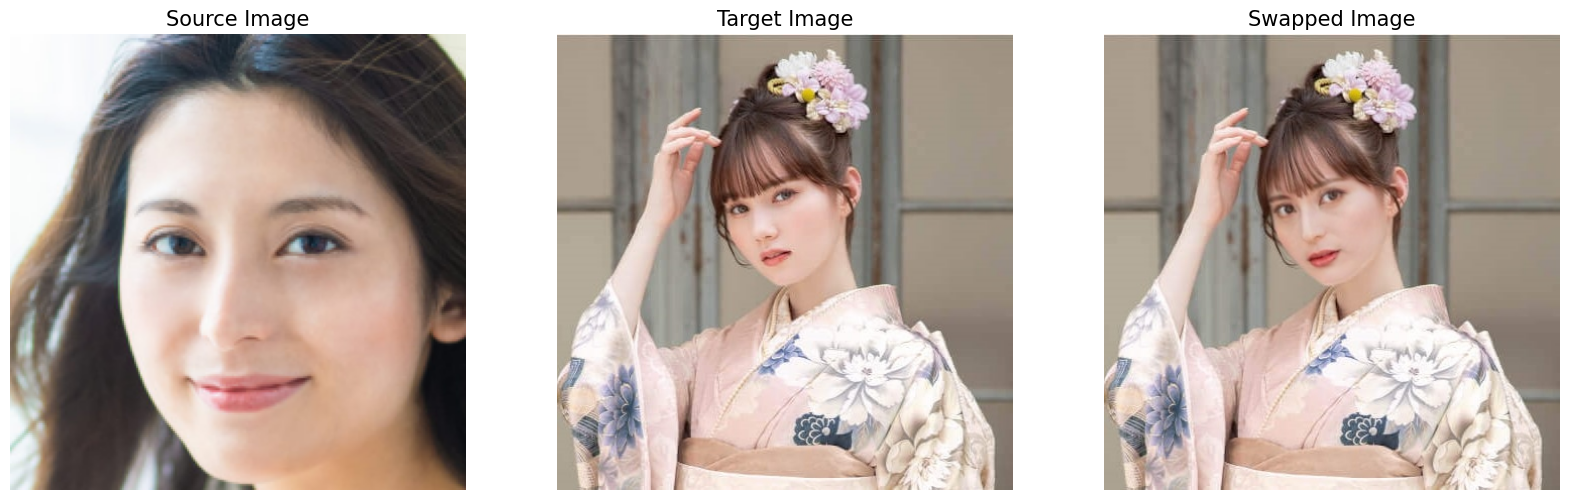

In [23]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from typing import Callable, List

import numpy as np
import torch
import cv2
from utils.inference.masks import face_mask_static 
from matplotlib import pyplot as plt
from insightface.utils import face_align

def show_face_frames(final_frames_list: List[List[np.ndarray]], 
                      titles: List[str] = None, 
                      figsize: tuple = (20, 5), 
                      fontsize: int = 15):
    """
    オプションのタイトルと共に最終フレームを表示する

    Args:
    final_frames_list (List[List[np.ndarray]]): 最終フレームのリストのリスト
    titles (List[str], optional): 各セットのタイトル。デフォルトはNone
    figsize (tuple, optional): 図のサイズ。デフォルトは(20, 5)
    fontsize (int, optional): タイトルのフォントサイズ。デフォルトは15
    """

    fig, axes = plt.subplots(1, len(final_frames_list), figsize=figsize)
    for idx, (ax, image) in enumerate(zip(axes, final_frames_list)):
        ax.imshow(image[0][:, :, ::-1])
        if titles:
            ax.set_title(titles[idx], fontsize=fontsize)
        ax.axis("off")
    plt.show()

def get_only_swaped_fullimage(final_frames: List[np.ndarray],
                          crop_frames: List[np.ndarray],
                          full_frame: np.ndarray,
                          tfm_arrays: List[np.ndarray]):
    """
    フェイススワッピングや他の画像変換の結果を用いて最終的な画像を生成する

    Args:
    final_frames (List[np.ndarray]): 最終的に生成されたフレームのリスト
    full_frame (np.ndarray): フルサイズの元のフレーム
    tfm_arrays (List[np.ndarray]): 各フレームに適用された変換行列のリスト
    """
    final = full_frame.copy()
    
    for frames, crop_frames, tfm_arrays in zip(final_frames_list, crop_frames_list, tfm_array_list):
        for frame, crop_frame, tfm_array in zip(frames, crop_frames, tfm_arrays):
            if frame.size > 0:
                frame_resized = cv2.resize(frame, (crop_frame.shape[1], crop_frame.shape[0]))
                mat_rev = cv2.invertAffineTransform(tfm_array)
                swap_t = cv2.warpAffine(frame_resized, mat_rev, (full_frame.shape[1], full_frame.shape[0]), borderMode=cv2.BORDER_REPLICATE)
                mask = cv2.warpAffine(np.ones_like(crop_frame[:, :, 0], dtype=np.uint8), mat_rev, (full_frame.shape[1], full_frame.shape[0]))
                mask = mask[:, :, np.newaxis]
                final = mask * swap_t + (1 - mask) * final
    
    final = np.array(final, dtype='uint8')
    return final

def get_only_swaped_faceimage(final_frames: List[np.ndarray],
                          crop_frames: List[np.ndarray],
                          full_frame: np.ndarray,
                          tfm_arrays: List[np.ndarray]):
    """
    フェイススワッピングや他の画像変換の結果を用いて最終的な画像を生成する

    Args:
    final_frames (List[np.ndarray]): 最終的に生成されたフレームのリスト
    full_frame (np.ndarray): フルサイズの元のフレーム
    tfm_arrays (List[np.ndarray]): 各フレームに適用された変換行列のリスト
    """
    # 各フレームに対応するパラメータのリスト（初期値はすべてNone）
    params = [None for i in range(len(final_frames))]
    
    # 各フレームについてループ
    for i in range(len(final_frames)):
        # 224x224ピクセルにリサイズされたフレームを取得
        frame = cv2.resize(final_frames[i][0], (224, 224))
        
        # リサイズされたフレームと対応するクロップフレームからランドマークを検出
        landmarks = handler.get_without_detection_without_transform(frame)     
        landmarks_tgt = handler.get_without_detection_without_transform(crop_frames[i][0])

        # face_mask_static関数を使用して、マスクと他の出力を取得
        mask, _ = face_mask_static(crop_frames[i][0], landmarks, landmarks_tgt, params[i])
        # 変換行列を反転
        mat_rev = cv2.invertAffineTransform(tfm_arrays[i][0])

        # リサイズされたフレームとマスクを元のフルサイズのフレームに再変換
        #swap_t = cv2.warpAffine(frame, mat_rev, (full_frame.shape[1], full_frame.shape[0]), borderMode=cv2.BORDER_REPLICATE)
        #mask_t = cv2.warpAffine(mask, mat_rev, (full_frame.shape[1], full_frame.shape[0]))
        #mask_t = np.expand_dims(mask_t, 2)

        # マスクを使用して変換されたフレームを最終フレームに適用
        final = mask*frame + (1-mask)*crop_frames[i][0]
    
    # 最終フレームをuint8型の配列に変換し、関数の結果として返す
    final = np.array(final, dtype='uint8')
    return final

# １．顔のクローズアップ
face_close_up = final_frames_list.copy()

# 後処理
#if True:
#    final_frames_list = get_only_swaped_faceimage(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list)

# 表示するタイトルを指定します
titles = ["not processing", "processing"]
face_close_up.append(final_frames_list[0])

# 画像として表示します
show_face_frames(face_close_up, titles, figsize=(8, 5))

# ２．全体
# 後処理なし
result = get_only_swaped_fullimage(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list)
show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))

# 後処理あり
result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))


In [ ]:
import sys
import argparse
import time
import cv2
import wandb
from PIL import Image
import os
import itertools

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as scheduler
from apex import amp
from network.AEI_Net import *
from network.MultiscaleDiscriminator import *
from utils.training.Dataset import FaceEmbedVGG2, FaceEmbed
from utils.training.image_processing import make_image_list, get_faceswap
from utils.training.losses import hinge_loss, compute_discriminator_loss, compute_generator_losses
from utils.training.detector import detect_landmarks, paint_eyes
from AdaptiveWingLoss.core import models
from arcface_model.iresnet import iresnet100

G_path = "./saved_weights/saved_models/stage3_identity_enhanced_4/G_latest.pth"
G.load_state_dict(torch.load(, map_location=torch.device('cpu')), strict=False)
#D.load_state_dict(torch.load(args.D_path, map_location=torch.device('cpu')), strict=False)
print("Loaded pretrained weights for G and D")
G.eval()

res1 = get_faceswap('examples/images/training//source1.png', 'examples/images/training//target1.png', G, netArc, device)
res2 = get_faceswap('examples/images/training//source2.png', 'examples/images/training//target2.png', G, netArc, device)  
res3 = get_faceswap('examples/images/training//source3.png', 'examples/images/training//target3.png', G, netArc, device)

res4 = get_faceswap('examples/images/training//source4.png', 'examples/images/training//target4.png', G, netArc, device)
res5 = get_faceswap('examples/images/training//source5.png', 'examples/images/training//target5.png', G, netArc, device)  
res6 = get_faceswap('examples/images/training//source6.png', 'examples/images/training//target6.png', G, netArc, device)

output1 = np.concatenate((res1, res2, res3), axis=0)
output2 = np.concatenate((res4, res5, res6), axis=0)

output = np.concatenate((output1, output2), axis=1)

In [ ]:
# 各変数のデータ構造と値をプリント
print("Final Frames List:")
print(f"Type: {type(final_frames_list)}")
for i, frames in enumerate(final_frames_list):
    print(f"Frame {i}:")
    print(f"Type: {type(frames)}")
    for frame in frames:
        if isinstance(frame, np.ndarray):
            print(f"Shape: {frame.shape}")
        print(frame)

print("\nCrop Frames List:")
print(f"Type: {type(crop_frames_list)}")
for i, frames in enumerate(crop_frames_list):
    print(f"Crop Frame {i}:")
    print(f"Type: {type(frames)}")
    for frame in frames:
        if isinstance(frame, np.ndarray):
            print(f"Shape: {frame.shape}")
        print(frame)

print("\nFull Frames:")
print(f"Type: {type(full_frames)}")
for i, frame in enumerate(full_frames):
    print(f"Full Frame {i}:")
    if isinstance(frame, np.ndarray):
        print(f"Shape: {frame.shape}")
    print(frame)

print("\nTransformation Array List:")
print(f"Type: {type(tfm_array_list)}")
for i, tfm_array in enumerate(tfm_array_list):
    print(f"Transformation Array {i}:")
    print(f"Type: {type(tfm_array)}")
    if isinstance(tfm_array, np.ndarray):
        print(f"Shape: {tfm_array.shape}")
    print(tfm_array)